# AdventureWorks Försäljningsanalys
I denna analys undersöker vi AdventureWorks- databasen för att besvara affärsfrågor som exempelvis:
- Produktkategorier och deras försäljning
- Försäljningstrender över tid
- Regional försäljning

Vi använder SQL för att hämta data och Python för visualisering och analys.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Zemer6969")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\kaisa\AppData\Local\Temp\ipykernel_6704\2621769548.py:23: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


In [2]:
def query_df(sql: str):
    with engine.connect() as conn:
        return pd.read_sql(text(sql), conn)

## Visualisering 1: Antal produkter per kategori
Hur många produkter finns i varje kategori?

Tabeller som används:
- Production.ProductCategory
- Production.ProductSubcategory
- Production.Product

Plan:
1. JOINa tabellerna 
2. Räkna DISTINCT produkt per kategori
3. Skapa verikalt stapeldiagram
4. Analysera resultatet

In [ ]:
query_vis1 = """
SELECT
    pc.Name AS CategoryName,
    COUNT (DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc 
INNER JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
LEFT JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name
ORDER BY ProductCount DESC
"""

df_vis1 = query_df(query_vis1)

,CategoryName,ProductCount
0,Components,134
1,Bikes,97
2,Clothing,35
3,Accessories,29


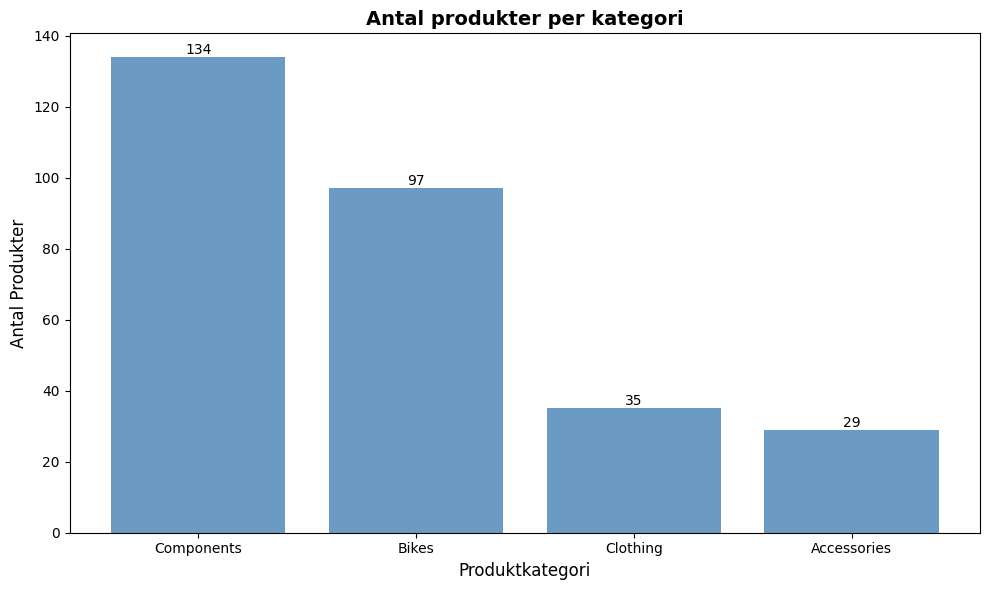

In [12]:
fig, ax = plt.subplots(figsize = (10, 6))

bars = ax.bar(df_vis1['CategoryName'], df_vis1['ProductCount'], color= 'steelblue', alpha= 0.8)

for bar in bars:
    height = bar.get_height()
    ax.text(
    bar.get_x() + bar.get_width()/2,
    height,
    f'{int(height)}',
    ha = 'center',
    va = 'bottom'
    )

ax.set_xlabel('Produktkategori', fontsize = 12)
ax.set_ylabel('Antal Produkter', fontsize = 12)
ax.set_title('Antal produkter per kategori', fontsize= 14, fontweight = 'bold')

plt.tight_layout()
plt.show()

### Insikter på antal produkter per kategori
Components är största kategorin med 134 produkter.
Accessories är minst med 29 produkter.

Detta indikerar på att företaget är stark fokuserad på komponenter och reservdelar. Och att accessories kan vara ett utvecklingsområde.